# Artificial Neural Networks with Keras

# The perceptron

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [2]:
#Loading the data
iris = load_iris()
X = iris.data[:,(2,3)] #Petal lenght and petal width only
Y = (iris.target == 0) # Iris setosa only

In [3]:
per_clf = Perceptron()
per_clf.fit(X,Y)

Perceptron()

In [4]:
y_pred = per_clf.predict([[2,0.5]])

In [5]:
y_pred ### Hard classification, no class probability 

array([False])

## The multilayer Perceptron and Backpropagation

An MLP is composed of one (passthrough) *input layer*, one or more layers of TLUs called *hidden layer*, and one final layer of TLUs called the *output layer*. The layer closed to the input layer are called *lower layers* and those close to the output layer are called *upper layers*. Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

When an ANN contains a deep stack of hidden layers, it is called a Deep Neural Network (DNN).

### Backpropagation training algorithm

* It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times. Each pass is called an *epoch*.

* Each mini-batch is passed to the network's input layer, which sends it to the first hidden layer. The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. This is the *forward pass*: it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.

* Next, the algorithm measures the network's output error (i.e., it uses a loss function that compares the desired output and the actual output of the network, and returns some measure of the error).

* Then it computes how much each output connection contributed to the error. This is done analytically by applying the chain rule, which makes this step fast and precise.

* The algorithm then measures how much of these error contributions came from each connection in the layer below, again using the chain rule, working backward until the algorithm reaches the input layer. This reverse pass efficiently measures the error gradient backward through the network.

* Finally the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

/!\ 
It is important to initialize all the hidden layer's connection weights randomly, or else the training will fail (because all the neurons in a giver layer will be identical, and thus backpropagation will affect them exactly in the same way, so they will remain identical, i.e. same as having one neuron by layer).
/!\

In order for this algorithm to work properly, the step function of the MLP's architecture has been changed to a logistic (sigmoid) function. Two other activation functions are *the hyperbolic tangent function* and the *the rectified Linear Unit function*.

## Regression MLPs

If we want to predict a single value, then we just need a single output neuron: Its output is the predicted value. For multivariate regression, we need one output per output dimension.

In general, when building an MLP for regression, we do not want to use any activation function for the output neurons, so they are free to output any range of values. If we want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer. We can also use the softplus activation function, which is close to 0 when z is negative and close to z when positive. FInally, if we want to guarantee that the predictions will fall within a given range of values, then we can use the logistic function or the hyperbolic tangent, and then scale the labels to the appropriate range: 0 to 1 for the logistic function and -1 to 1 for the hyperbolic tangent.

The loss function to use during training is typically the mean square error but if we have a lot of outliers in the training set, we may prefer to use the mean absolute error instead. Alternatively we can use the Huber loss, which is a combination of both.

## Classification MLPs

For a binay classification problem, we just need a single output neuron using the logistic activation function: the output will be a number between 0 and 1, which we can interpret as the estimated probability of the positive class.

MLPs can also handle multilabel binary classification tasks. If each instance can belong only to a single class, then we need to have one output neuron per class, and we should use the softmax activation function for the whole output layer. The softmax function for the whole output layer. The softmax function will ensure that all the estimated probabilities are between 0 and 1 and that they are add up to 1. This is called multiclass classification.

Regarding the loss function, the cross-entropy loss (log-loss) is generally a good choice.

## Implementing MLP with Keras!

In [6]:
import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
tf.__version__

'2.0.0'

In [9]:
keras.__version__

'2.2.4-tf'

In [10]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full,y_train_full),(X_test,y_test) = fashion_mnist.load_data()

In [11]:
X_train_full.shape

(60000, 28, 28)

In [12]:
X_train_full.dtype

dtype('uint8')

In [13]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0 #Divide by 255 to scale and create a validation set
y_valid,y_train = y_train_full[:5000], y_train_full[5000:]

In [14]:
### Class names for the predictions
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle Boot"]

In [15]:
class_names[y_train[1]]

'T-shirt/top'

## Creating the model using Sequential API

In [16]:
# Two hidden layers
model = keras.models.Sequential() # Creating the sequential model
model.add(keras.layers.Flatten(input_shape=[28,28])) #Convert each image into a 1D array, could also add keras.layers.InputLayer
model.add(keras.layers.Dense(300,activation="relu")) #Hidden layer with 300 neurons and relu activation function
model.add(keras.layers.Dense(100,activation="relu")) #Hidden layer with 100 neurons and relu activation function
model.add(keras.layers.Dense(10,activation="softmax")) #Hidden layer with 10 neurons, one by class and softmax activation function for prediction

## Also working!!
#model = keras.models.Sequential([
#    model.add(keras.layers.Flatten(input_shape=[28,28])) 
#    model.add(keras.layers.Dense(300,activation="relu")) 
#    model.add(keras.layers.Dense(100,activation="relu")) 
#    model.add(keras.layers.Dense(10,activation="softmax"))
#])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


The first Dense layer has 784 x 300 connection weights, plus 300 bias terms which adds up to 235500 parameters!

In [18]:
model.layers # List of layers

In [19]:
hidden1 = model.layers[1]

In [20]:
hidden1.name

'dense'

In [21]:
model.get_layer("dense") is hidden1

True

In [22]:
weights, bias = hidden1.get_weights() #The weights and bias of the layer

In [23]:
weights.shape

(784, 300)

In [24]:
bias.shape

(300,)

In [25]:
# Compiling the model

model.compile(loss="sparse_categorical_crossentropy", #Because of sparse labels and classes are exclusive
             optimizer="sgd", #Stochastic Gradient Descent
             metrics=["accuracy"]) #Accuracy as a metric

In [26]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid)) #validation_split can be used to get a validation set

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 6s 112us/sample - loss: 0.7156 - accuracy: 0.7659 - val_loss: 0.5191 - val_accuracy: 0.8168
Epoch 2/30
55000/55000 [==============================] - 5s 99us/sample - loss: 0.4865 - accuracy: 0.8315 - val_loss: 0.4820 - val_accuracy: 0.8348
Epoch 3/30
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4431 - accuracy: 0.8452 - val_loss: 0.4032 - val_accuracy: 0.8652
Epoch 4/30
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4161 - accuracy: 0.8539 - val_loss: 0.4188 - val_accuracy: 0.8486
Epoch 5/30
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3973 - accuracy: 0.8602 - val_loss: 0.3901 - val_accuracy: 0.8600
Epoch 6/30
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3813 - accuracy: 0.8660 - val_loss: 0.3869 - val_accuracy: 0.8668
Epoch 7/30
55000/55000 [=============================

If the training set was very skewed, with some classes being overrepresented and others underrepresented, it would be useful to set the class_weight argument when calling the fit() method, which would give a larger weight to underrepresented classes and a lower weight to overrepresented classes. If we need per-instances weights, sample_weight argument (supersedes class_weight). It could be useful if some instances were labeled by experts while others by crowdsourcing platform (we might want to give more weight to the last one). Sample weights can also be added for the validation set by adding them as a third item in the validation_data tuple.

The fit() method returns a history object containing the training parameters (history.params), the list of epochs it went through (history.epoch) and most importantly a dictionnary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

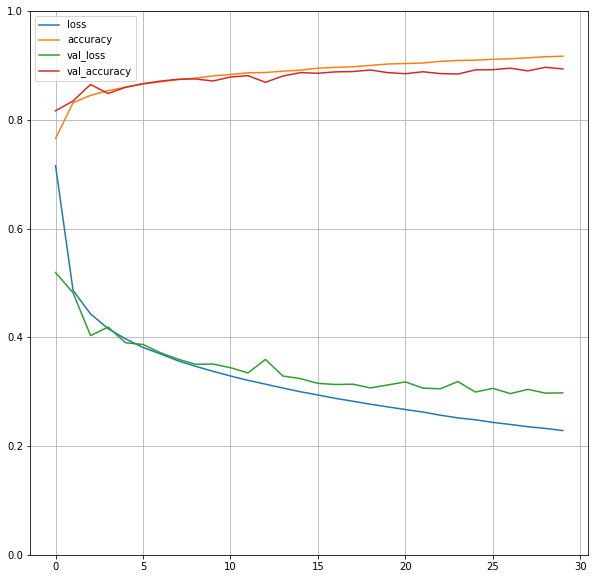

In [28]:
pd.DataFrame(history.history).plot(figsize=(10,10)) #the training curve should be ploted to half an epoch to the left as the training error is computed during the epoch
plt.grid(True)
plt.gca().set_ylim(0,1) #vertical range [0,1]
plt.show()

The training is not over as the model has not converged yet because the validation loss is still going down.

In [29]:
model.evaluate(X_test,y_test) #loss: 29.5611 - accuracy: 0.8534, DO NOT TWEAK THE PARAMETERS ON TEST SET TO AVOID OVERFITTING

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[61.032970940846205, 0.8465]

In [30]:
# Making prediction
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [31]:
y_pred = model.predict_classes(X_new)
print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1]
['Ankle Boot' 'Pullover' 'Trouser']


## Building a Regression MLP Using the Sequential API

In [32]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
housing = fetch_california_housing()

In [34]:
X_train_full,X_test,y_train_full,y_test = train_test_split(housing.data, housing.target)

In [35]:
X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,y_train_full)

In [36]:
scaler = StandardScaler()

In [37]:
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [38]:
model = keras.models.Sequential([
    keras.layers.Dense(30,activation="relu",input_shape=X_train.shape[1:]),
    keras.layers.Dense(1) #One neuron only to predict a single value
])
model.compile(loss="mean_squared_error",optimizer="sgd")
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_valid,y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 93us/sample - loss: 0.8668 - val_loss: 2.2648
Epoch 2/20
11610/11610 [==============================] - 1s 73us/sample - loss: 2.0358 - val_loss: 0.4598
Epoch 3/20
11610/11610 [==============================] - 1s 60us/sample - loss: 0.4667 - val_loss: 0.3845
Epoch 4/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4176 - val_loss: 0.3791
Epoch 5/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4300 - val_loss: 0.3786
Epoch 6/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3937 - val_loss: 0.3615
Epoch 7/20
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3824 - val_loss: 0.3572
Epoch 8/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4797 - val_loss: 0.4016
Epoch 9/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.4158 - val_l

In [39]:
mse_test = model.evaluate(X_test,y_test) #loss: 0.8789

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [40]:
X_new = X_test[3:]
y_pred = model.predict(X_new)

In [41]:
from sklearn.metrics import mean_squared_error

In [42]:
mean_squared_error(y_pred,y_test[3:])

0.35854949984262374

## Building Complex Models Using the Functional API

In [43]:
## Wide and Deep Neural Network

input_ = keras.layers.Input(shape=X_train.shape[1:]) #Input object
hidden1 = keras.layers.Dense(30,activation="relu")(input_) #30 neurons, activation function relu, connected to input
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1) #30 neurons, activation function relu, connected to hidden1
concat = keras.layers.Concatenate()([input_,hidden2]) #Concat the two paths
output = keras.layers.Dense(1)(concat) # On neuron for prediction
model = keras.Model(inputs=[input_],outputs=[output])

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [45]:
###Subet of the feature through the wide path and some through the deep path

input_A = keras.layers.Input(shape=[5],name="wide_input")
input_B = keras.layers.Input(shape=[6],name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A,hidden2])
output = keras.layers.Dense(1,name="output")(concat)
model = keras.Model(inputs=[input_A,input_B],outputs=[output])

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 30)           930         dense_8[0][0]                    
____________________________________________________________________________________________

In [47]:
model.compile(loss="mse",optimizer="sgd")

In [48]:
X_train_A, X_train_B = X_train[:,:5],X_train[:,2:]
X_valid_A, X_valid_B = X_valid[:,:5],X_valid[:,2:]

X_test_A, X_test_B = X_test[:,:5],X_test[:,2:]
X_new_A, X_new_B = X_test_A[:3],X_test_B[:3]

In [49]:
history = model.fit((X_train_A,X_train_B),y_train, epochs=20,
                    validation_data=((X_valid_A,X_valid_B),y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 112us/sample - loss: 0.9275 - val_loss: 3.3582
Epoch 2/20
11610/11610 [==============================] - 1s 66us/sample - loss: nan - val_loss: nan
Epoch 3/20
11610/11610 [==============================] - 1s 79us/sample - loss: nan - val_loss: nan
Epoch 4/20
11610/11610 [==============================] - 1s 73us/sample - loss: nan - val_loss: nan
Epoch 5/20
11610/11610 [==============================] - 1s 64us/sample - loss: nan - val_loss: nan
Epoch 6/20
11610/11610 [==============================] - 1s 64us/sample - loss: nan - val_loss: nan
Epoch 7/20
11610/11610 [==============================] - 1s 64us/sample - loss: nan - val_loss: nan
Epoch 8/20
11610/11610 [==============================] - 1s 67us/sample - loss: nan - val_loss: nan
Epoch 9/20
11610/11610 [==============================] - 1s 61us/sample - loss: nan - val_loss: nan
Epoch 10/20
11610/11610 [==========

In [50]:
mse_test = model.evaluate((X_test_A,X_test_B),y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [51]:
y_pred = model.predict((X_new_A,X_new_B))

In [52]:
y_pred

array([[nan],
       [nan],
       [nan]], dtype=float32)

There are many use cases in which we may want to have a multiple outputs:
* Locate and classify the main object in a picture (coordinate of the object's center and classification)
* Multiple independent tasks on the same data (like multitask classification on pictures of faces, to recognize the person's facial expression and / or wearing sunglasses)
* Regularization technique (to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network).

In [53]:
##Adding extra outputs

###Subet of the feature through the wide path and some through the deep path

input_A = keras.layers.Input(shape=[5],name="wide_input")
input_B = keras.layers.Input(shape=[6],name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A,hidden2])
output = keras.layers.Dense(1,name="main_output")(concat)
aux_output = keras.layers.Dense(1,name="aux_output")(hidden2)
model_aux_output = keras.Model(inputs=[input_A,input_B],outputs=[output,aux_output])

In [54]:
model_aux_output.compile(loss=["mse","mse"],loss_weights=[0.9,0.1],optimizer="sgd") #Each output has its own loss function, and we weight them by importance

In [55]:
model_aux_output.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 30)           930         dense_10[0][0]                   
____________________________________________________________________________________________

In [56]:
history = model_aux_output.fit(
    [X_train_A,X_train_B],[y_train,y_train],epochs=20,validation_data=([X_valid_A,X_valid_B],[y_valid,y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 132us/sample - loss: 1.0315 - main_output_loss: 0.8864 - aux_output_loss: 2.3349 - val_loss: 0.6356 - val_main_output_loss: 0.5539 - val_aux_output_loss: 1.3709
Epoch 2/20
11610/11610 [==============================] - 1s 70us/sample - loss: 0.6272 - main_output_loss: 0.5486 - aux_output_loss: 1.3344 - val_loss: 0.5699 - val_main_output_loss: 0.5016 - val_aux_output_loss: 1.1859
Epoch 3/20
11610/11610 [==============================] - 1s 69us/sample - loss: 0.5844 - main_output_loss: 0.5213 - aux_output_loss: 1.1508 - val_loss: 0.5151 - val_main_output_loss: 0.4578 - val_aux_output_loss: 1.0321
Epoch 4/20
11610/11610 [==============================] - 1s 71us/sample - loss: 0.5369 - main_output_loss: 0.4846 - aux_output_loss: 1.0064 - val_loss: 0.4853 - val_main_output_loss: 0.4393 - val_aux_output_loss: 0.9002
Epoch 5/20
11610/11610 [==============================] - 1s 69us/

In [57]:
total_loss,main_loss,aux_loss = model_aux_output.evaluate([X_test_A,X_test_B],[y_test,y_test])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [58]:
print(total_loss,main_loss,aux_loss)

0.3566125635490861 0.34046096 0.4900416


In [59]:
y_pred_main,y_pred_aux = model_aux_output.predict([X_new_A,X_new_B])

In [60]:
print(y_pred_main,y_pred_aux)

[[1.3163   ]
 [1.7210016]
 [1.2640159]] [[1.1649575]
 [1.4253073]
 [1.2951183]]


## Using the Subclassing API to Build Dynamic Models

In [61]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation = "relu", **kwargs):
        super().__init__(**kwargs) #handles standars args (like names,etc.)
        self.hidden1 = keras.layers.Dense(units,activation=activation)
        self.hidden2 = keras.layers.Dense(units,activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self,inputs):
        input_A,input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(input_1)
        concat = keras.layers.concatenate([input_A,hidden2])
        main_output = self.main_output(concat)
        return main_output, aux_output

In [62]:
model_subclassing_api = WideAndDeepModel()

## Saving and Restoring a Model

In [63]:
model_aux_output.save("my_keras_aux_model.h5")  #To save the model created

## Loading the model
# model = keras.models.load_model("my_keras_model.h5")

This will work when using the sequential API or functional API, not when using the subclassing. For the subclassing, save_weights() and load_weights() can be used to save weights and restore them but the rest needs to be imported by ourself.

## Using Callbacks

In [64]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5")
#history = model.fit(X_train,y_train,epochs=10,callbacks=[checkpoint_cb]) #To save the model at every epoch

In [65]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",save_best_only=True)
#history = model.fit(X_train,y_train,epochs=10,callbacks=[checkpoint_cb]) #To save the model at the best model

In [66]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, #Number of epochs before stopping if the score doesn't improve
                                                 restore_best_weights=True)

In [67]:
#history = model.fit(X_train,y_train,epochs=10,callbacks=[checkpoint_cb,early_stopping_cb]) #To save the model at the best model and early stopping

In [68]:
## Custom callbacks

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs): #can be implemented on on_batch_begin(),on_train_begin(),on_test_batch_end(),etc.
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

## TensorBoard for Visualization

In [69]:
import os

root_logdir = os.path.join(os.curdir,"my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

In [70]:
run_logdir = get_run_logdir()

In [71]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [72]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full,y_train_full),(X_test,y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0 #Divide by 255 to scale and create a validation set
y_valid,y_train = y_train_full[:5000], y_train_full[5000:]

In [73]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(10,activation="softmax")])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

history = model.fit(X_train,y_train,
                   epochs=30,
                   validation_data=(X_valid,y_valid),
                   callbacks=[tensorboard_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 6s 109us/sample - loss: 0.7147 - accuracy: 0.7633 - val_loss: 0.5366 - val_accuracy: 0.8062
Epoch 2/30
55000/55000 [==============================] - 6s 101us/sample - loss: 0.4882 - accuracy: 0.8300 - val_loss: 0.4433 - val_accuracy: 0.8488
Epoch 3/30
55000/55000 [==============================] - 6s 100us/sample - loss: 0.4414 - accuracy: 0.8449 - val_loss: 0.4071 - val_accuracy: 0.8614
Epoch 4/30
55000/55000 [==============================] - 6s 100us/sample - loss: 0.4137 - accuracy: 0.8555 - val_loss: 0.4092 - val_accuracy: 0.8582
Epoch 5/30
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3928 - accuracy: 0.8632 - val_loss: 0.3914 - val_accuracy: 0.8644
Epoch 6/30
55000/55000 [==============================] - 5s 100us/sample - loss: 0.3777 - accuracy: 0.8668 - val_loss: 0.3738 - val_accuracy: 0.8734
Epoch 7/30
55000/55000 [===========================

## Fine-Tuning Neural Network Hyperparameters

In [74]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)